# The introductory computer exercise using Python and the SUND toolbox

This version of the exercise is implemented as a Python version using the SUND toolbox, running in an iPython notebook. The notebook can either be [run online in Google colab](https://colab.research.google.com/drive/1y37yYcxwSj5yd0yUePGxtvXZhJNkxf_-?usp=sharing), or <a href="https://isbgroup.eu/edu/courses/intro/computer_exercise/python_sund.ipynb" download>downloaded</a> and run locally.

Note: if running in Google colab, your downloaded and created files will be deleted after you close the session. If you decide to use it, make sure that you download backups! Furthermore, the first thing you should do is to save a copy of the notebook. To do this, press `File > Save a copy in Drive`.

## Introduction

### Purpose of the lab

This lab will on a conceptual level guide you through all the main sub-tasks in a systems biology project: model creation, model training using experimental data, model evaluation, and finally using the model to make predictions of new experiments.

This is an example of the steps the students should do in the exercise, but here implemented in Python. Step 0 revolves around setting up the environment, which will of course be very different when running in system modeller. In this example, I will lump together quite a lot of steps since they will most likely be completely different in the system modeller implementation

## Step 0: Setting up the environment

<details class="admonition success"><summary> Setting up the simulation toolbox</summary>

First make sure that you have a c-compiler installed. If you are running a unix-based operating system such as Mac OS or Linux you will have c-compiler already installed.

For Windows users you will need to install a c-compiler, for the newer Python distribution (version > 3.4) you will need to install the Microsoft Visual C++ compiler (MSVC). This can either be installed as a part of Visual Studios or as a standalone installation using Visual Studios Build Tools. [Here](https://wiki.python.org/moin/WindowsCompiler) can you see which compiler you need for your Python installations and follow the links to install the compiler.

Make sure you have pip (the Python package installer) installed: From the terminal (Unix-users) or command window (Windows-users) try running `pip --version` (Linux users may have to write `pip3`). If `pip` is not installed, follow instructions [here](https://packaging.python.org/tutorials/installing-packages/) to install it.

When you have ensured that pip is installed, check that setuptools and wheel are installed by running `pip show setuptools`. If installed it should show information about the setuptools package, such as version number. If not installed you can install it using pip: `pip install wheel setuptools`.

After that you also need to install `numpy`, `matplotlib`, `jupyter` and the [`SUND toolbox`](https://isbgroup.eu/edu/assets/sund-1.0.3.1.tar.gz). The easiest way is to install the packages using `pip install ...` (e.g., `pip install numpy matplotlib jupyter https://isbgroup.eu/edu/assets/sund-1.0.4.tar.gz`).

</details>

Note, if running on Google Colab, you must use the cell below, and the packages will only be installed on the remote connection, not on your local computer. 

You can also use this cell if running the notebook on your own computer, but be aware that it will install packages in the current environment.

In [ ]:
# Installing packages. Warning, this code cell will install packages to your computer.
#%pip install numpy matplotlib jupyter
#%pip install https://isbgroup.eu/sund-toolbox/releases/sund-1.1.0.tar.gz

In [ ]:
# Import packages
import sys
import os
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import sund
import json
from scipy.stats import chi2
from scipy.optimize import Bounds
from scipy.optimize import differential_evolution
import csv
import random
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from contextlib import contextmanager

# Setup numpy -> json encoder (might not be needed)
from json import JSONEncoder
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
    
# Define a function to silence errors in simulations
@contextmanager
def silent_errors(stdchannel=sys.stderr, dest_filename=os.devnull):
    try:
        oldstdchannel = os.dup(stdchannel.fileno())
        dest_file = open(dest_filename, 'w')
        os.dup2(dest_file.fileno(), stdchannel.fileno())
        yield
    finally:
        if oldstdchannel is not None:
            os.dup2(oldstdchannel, stdchannel.fileno())
        if dest_file is not None:
            dest_file.close()


Download the data

In [ ]:
# Download the experimental data:
#!curl https://isbgroup.eu/edu/assets/Intro/Files/data_2024-03-12.json > data_2024-03-12.json

DATA = json.load(open('data.json', 'r'))
ALL_DATA_TIMES = sorted(set([t for experiment in DATA for k,d in DATA[experiment].items() if "time" in d for t in d["time"] ]))

for experiment in DATA:
    for k,d in DATA[experiment].items():
        if "time" in d:
            d["time"] = np.array(d["time"])
        if "data" in d:
            d["data"] = np.array(d["data"])
        if "error" in d:
            d["error"] = np.array(d["error"])

## Step 1: Implement a minimal model to get familiar with the software

Implement a first minimal model for NFKB activation
(This will most likely be given to the students, so that they have something to start with, to understand the basics of the software)

This is the model to implement: 

![simple_model](assets/simple_model.svg)

In this version, these are the ODEs used: 

```c

########## STATES
d/dt(NFKBinactive) = -vact + vinact
d/dt(NFKBactive)   =  vact - vinact

NFKBinactive(0)=100
NFKBactive(0)=0

########## PARAMETERS
k1 = 1 //values does not mean anything, overwritten later
k2 = 1

########## VARIABLES
vact   = LPS * NFKBinactive * k1 
vinact = NFKBactive * k2 

```

Make a first simulation, play around with changing the parameter values and simulation length.

(change time in the code to change the simulated time)

In [ ]:
# Install/load the model (note that the notebook must be restarted if the model file is updated)
sund.installModel('models/simple.txt')
Simple = sund.importModel('simple')
simple = Simple() # get the object from the model class

theta = [0.01, 0.6, 0.04] # Only for debugging

# Define functions to simulate and plot the simulation
def plot_feature(simulation, featurename, experiment):
    plt.plot(simulation['time'], simulation[featurename])
    plt.xlabel('Time')
    plt.ylabel('Response (a.u.)')
    plt.title(f"{experiment} - {featurename}")

def simulate_and_plot(simulations, time, params=[1,2], features_to_plot = None):

    for experiment, simulation in simulations.items():
        if experiment in DATA:
            data = DATA[experiment]

        if features_to_plot is None:
            features_to_plot = simulation.featurenames

        simulation.Simulate(timevector = time, resetstatesderivatives=True, parametervalues=params)
        feature_data = simulation.featuredata_dict()
        feature_data["time"] = simulation.timevector
        for feature in features_to_plot:
            plt.figure()
            plot_feature(feature_data, feature, experiment)
            if feature in data:
                data_feature= data[feature]
                plt.errorbar(data_feature["time"], data_feature["mean"], data_feature["sem"], fmt='o')

# Setup simulation
def setup_simulation(model, glucose = {"t": [5], "f":[0,0]}, insulin={"t": [5], "f":[0,0]}):
    stimulation_activity = sund.Activity(timeunit='m')
    stimulation_activity.AddOutput(sund.PIECEWISE_CONSTANT, 'glucose_input', tvalues=glucose["t"], fvalues=glucose["f"])
    stimulation_activity.AddOutput(sund.PIECEWISE_CONSTANT, 'insulin_input', tvalues=insulin["t"], fvalues=insulin["f"])
    simulation = sund.Simulation(timeunit='m', models=model, activities=stimulation_activity)
    return simulation

# Simulate and plot
sims_simple = {}
sims_simple["OGTT 75g"] = setup_simulation(simple, glucose = DATA["OGTT 75g"]["input"]["glucose"])
time = np.linspace(0, 180, 1000)

k1_slider = widgets.FloatSlider(min=0.00001, max=0.05, step=0.0001, value=0.01)
k2_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.0001, value=0.6)
k3_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.0001, value=0.04)

@interact(k1=k1_slider, k2=k2_slider, k3=k3_slider)
def handle_input(k1=0.01, k2=0.03, k3 = 0.03):
    simulate_and_plot(sims_simple, time, [k1,k2, k3])
    # plt.show()

In this version, glucose is simply being taken up, but we know that this is due to insulin being secreted

In [ ]:
# Install/load the model (note that the notebook must be restarted if the model file is updated)
sund.installModel('models/first_insulin.txt')
First_insulin = sund.importModel('first_insulin')
first_insulin = First_insulin() # get the object from the model class

theta0 = [0.01, 0.03, 0.01, 0.03, 1]

feature_indices = {k:i for i,k in enumerate(first_insulin.featurenames)}

sims_first_insulin = {}
sims_first_insulin["OGTT 75g"] = setup_simulation(first_insulin, glucose = DATA["OGTT 75g"]["input"]["glucose"])

In [ ]:
# Optimize the parameter values to get a good solution
def cost_f(p, simulations):
    cost = 0
    for experiment, data in DATA.items():
        simulation = simulations[experiment]
        try:
            simulation.Simulate(timevector = ALL_DATA_TIMES, resetstatesderivatives=True, parametervalues=p)
            for feature, data_feature in DATA[experiment].items():
                if feature in simulation.featurenames:
                    t_overlap = np.searchsorted(simulation.timevector, data_feature["time"])
                    y_sim = simulation.featuredata[:, feature_indices[feature]]
                    cost += np.sum(np.square((y_sim[t_overlap] - data_feature["mean"])/ data_feature["sem"]))
        except Exception as e: # If simulation fails
            cost += 1e20
    return cost

def cost_log(p, simulations):
    return cost_f(np.exp(p), simulations)

bounds = Bounds([np.log(1e-6)]*len(theta0), [np.log(1e6)]*len(theta0))
theta0_log = np.log(theta0)
with silent_errors():
    result = differential_evolution(cost_log, bounds, x0 = theta0_log, args=(sims_first_insulin,), maxiter=1000, disp=True)
result['x'] = np.exp(result['x']).tolist()
theta0 = result["x"]

simulate_and_plot(sims_first_insulin, time, theta0)

print(f"theta = {theta0}")

In [ ]:
# Setup sliders
theta= [0.02116556130636561, 0.05065273217459981, 0.00013656522618978048, 29026.238494314388, 756.5170187028791]

k1_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.0001, value=0.02)
k2_slider = widgets.FloatSlider(min=0.00001, max=100, step=0.001, value=0.05)
k3_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.00001, value=0.00013)
k4_slider = widgets.FloatSlider(min=0.001, max=100000, step=1, value=29026)
k5_slider = widgets.FloatSlider(min=0.01, max=1000, step=1, value=756)

# Simulate and plot
time = np.linspace(0, 180, 1000)
@interact(k1=k1_slider, k2=k2_slider, k3=k3_slider, k4=k4_slider, k5=k5_slider)
def handle_input(k1=0.2, k2=0.1, k3=0.2, k4=0.1, k5=0.05):
    simulate_and_plot(sims_first_insulin, time, [k1,k2, k3, k4, k5])
    plt.show()

Now, we can use the model with the given parameters to simulate the longer term response. Is it reasonable? 

In [ ]:
# theta = [k1_slider.value, k2_slider.value, k3_slider.value, k4_slider.value, k5_slider.value]
theta= [0.02116556130636561, 0.05065273217459981, 0.00013656522618978048, 29026.238494314388, 756.5170187028791]

time_long = np.linspace(0, 540, 1000)
simulate_and_plot(sims_first_insulin, time_long, theta)

We need to introduce a basal level of glucose, primarily from the liver.

In [24]:
# Install/load the model (note that the notebook must be restarted if the model file is updated)
sund.installModel('models/pancreas_liver.txt')
Pancreas_liver = sund.importModel('pancreas_liver')
pancreas_liver = Pancreas_liver() # get the object from the model class

theta0 = [0.02, 0.05, 0.00013, 29026, 756, 1,1, 1]

feature_indices = {k:i for i,k in enumerate(pancreas_liver.featurenames)}

sims_pancreas_liver = {}
sims_pancreas_liver["OGTT 75g"] = setup_simulation(pancreas_liver, glucose = DATA["OGTT 75g"]["input"]["glucose"])

Model 'pancreas_liver' is already installed and up to date.



[CVODE WARNING]  CVode
  Internal t = 15.64 and h = 8.37896e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 15.64 and h = 8.37896e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 15.64 and h = 8.37896e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 15.64 and h = 8.37896e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 15.64 and h = 8.37896e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 15.64 and h = 8.37896e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 15.64 and h = 8.37896e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

differential_evolution step 1: f(x)= 15.632566650868785
differential_evolution step 2: f(x)= 15.632566650868785



[CVODE WARNING]  CVode
  Internal t = 145.923 and h = 1.26265e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 145.923 and h = 1.26265e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 145.923 and h = 1.26265e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 145.923 and h = 1.26265e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 145.923 and h = 1.26265e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 145.923 and h = 1.26265e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 145.923 and h = 1.26265e-14 are such that t + h = t on the next step. The solver will continue anyway.


differential_evolution step 3: f(x)= 15.632566650868785
differential_evolution step 4: f(x)= 15.632566650868785



[CVODE WARNING]  CVode
  Internal t = 10.4418 and h = 6.5354e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 10.4418 and h = 6.5354e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 10.4418 and h = 6.5354e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 10.4418 and h = 6.5354e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 10.4418 and h = 6.5354e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 10.4418 and h = 6.5354e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 10.4418 and h = 6.5354e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVOD

differential_evolution step 5: f(x)= 15.632566650868785
differential_evolution step 6: f(x)= 15.632566650868785
differential_evolution step 7: f(x)= 15.632566650868785
differential_evolution step 8: f(x)= 15.632566650868785



[CVODE WARNING]  CVode
  Internal t = 110.273 and h = 6.3217e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 110.273 and h = 6.3217e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 110.273 and h = 6.3217e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 110.273 and h = 6.3217e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 110.273 and h = 6.3217e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 110.273 and h = 6.3217e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 110.273 and h = 6.3217e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVOD

differential_evolution step 9: f(x)= 15.632566650868785
differential_evolution step 10: f(x)= 15.632566650868785
differential_evolution step 11: f(x)= 15.632566650868785
differential_evolution step 12: f(x)= 15.632566650868785



[CVODE WARNING]  CVode
  Internal t = 11.6175 and h = 6.73788e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 11.6175 and h = 6.73788e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 11.6175 and h = 6.73788e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 11.6175 and h = 6.73788e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 11.6175 and h = 6.73788e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 11.6175 and h = 6.73788e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 11.6175 and h = 6.73788e-16 are such that t + h = t on the next step. The solver will continue anyway.


differential_evolution step 13: f(x)= 15.632566650868785
differential_evolution step 14: f(x)= 15.632566650868785
differential_evolution step 15: f(x)= 15.632566650868785
differential_evolution step 16: f(x)= 15.632566650868785



[CVODE WARNING]  CVode
  Internal t = 2.62422 and h = 1.62044e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 2.62422 and h = 1.62044e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 2.62422 and h = 1.62044e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 2.62422 and h = 1.62044e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 2.62422 and h = 1.62044e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 2.62422 and h = 1.62044e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 2.62422 and h = 1.62044e-16 are such that t + h = t on the next step. The solver will continue anyway.


differential_evolution step 17: f(x)= 15.632566650868785
differential_evolution step 18: f(x)= 15.632566650868785
differential_evolution step 19: f(x)= 15.632566650868785
differential_evolution step 20: f(x)= 15.632566650868785
differential_evolution step 21: f(x)= 15.632566650868785
differential_evolution step 22: f(x)= 15.632566650868785
differential_evolution step 23: f(x)= 15.632566650868785
differential_evolution step 24: f(x)= 15.632566650868785
differential_evolution step 25: f(x)= 15.632566650868785
differential_evolution step 26: f(x)= 15.632566650868785
differential_evolution step 27: f(x)= 15.632566650868785
differential_evolution step 28: f(x)= 15.632566650868785
differential_evolution step 29: f(x)= 15.632566650868785
differential_evolution step 30: f(x)= 15.632566650868785
differential_evolution step 31: f(x)= 15.632566650868785
differential_evolution step 32: f(x)= 15.632566650868785
differential_evolution step 33: f(x)= 15.632566650868785
differential_evolution step 34:

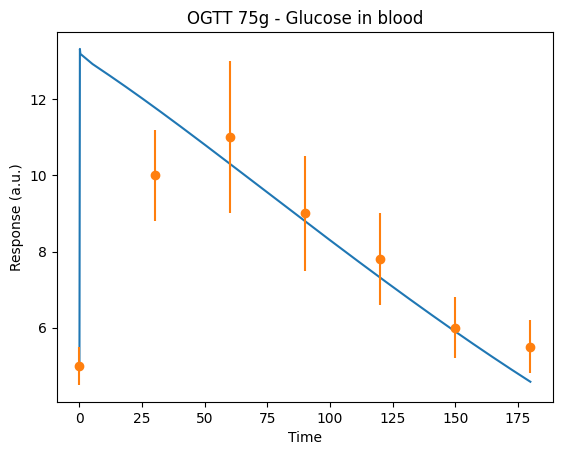

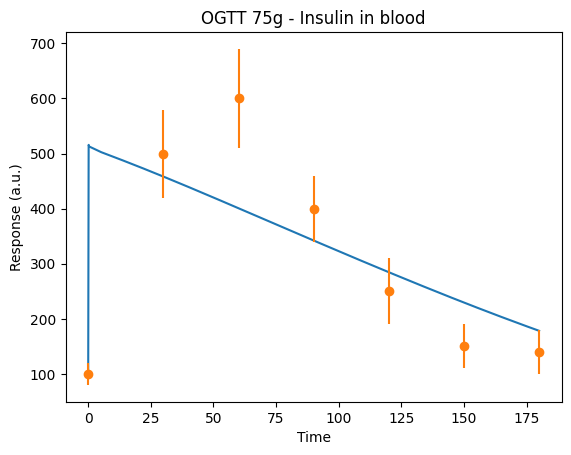

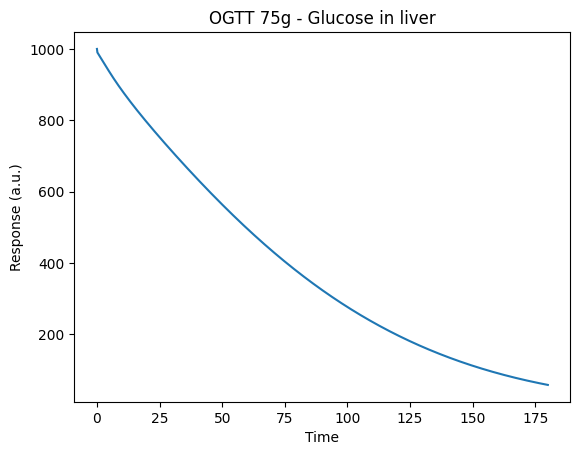

In [26]:
bounds = Bounds([np.log(1e-6)]*len(theta0), [np.log(1e6)]*len(theta0))
theta0_log = np.log(theta0)
with silent_errors():
    result = differential_evolution(cost_log, bounds, x0 = theta0_log, args=(sims_first_insulin,), maxiter=1000, disp=True)
result['x'] = np.exp(result['x']).tolist()
theta0 = result["x"]

simulate_and_plot(sims_first_insulin, time, theta0)

print(f"theta = {theta0}")